# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv?etag=11687de0e23962e5a11c9d8ae13eb630',
                 index_col=[0], parse_dates=[0])
print(df.index.is_monotonic_increasing)
print()
print(df.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [3]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [4]:
df.isna().count()

num_orders    4416
dtype: int64

In [5]:
df[df.isna().any(axis=1)]

,num_orders
datetime,


<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

<b>Éxito</b> - Has comenzado el proyecto de forma sólida. La lectura del dataset, la conversión del índice a fechas y el remuestreo por hora están correctamente implementados. Esta preparación es esencial para análisis de series temporales y sienta una base limpia para modelado futuro. También verificaste si el índice está ordenado cronológicamente, lo cual es una buena práctica.

Además, hiciste una revisión de valores ausentes y localizaste correctamente las filas donde existen, aunque podrías complementarlo detallando cómo los abordarás (por ejemplo, interpolación, eliminación o relleno con ceros).

Como sugerencia para esta fase inicial:

- Considera visualizar los datos remuestreados para validar patrones o anomalías desde el inicio.
- Incluir una visualización rápida de la serie temporal en crudo puede ayudar a anticipar estacionalidad, tendencia o eventos atípicos.

Excelente comienzo para este proyecto de predicción de demanda horaria. Continúa con el análisis exploratorio para detectar patrones y preparar el terreno para el modelado predictivo.

</div>


## Análisis

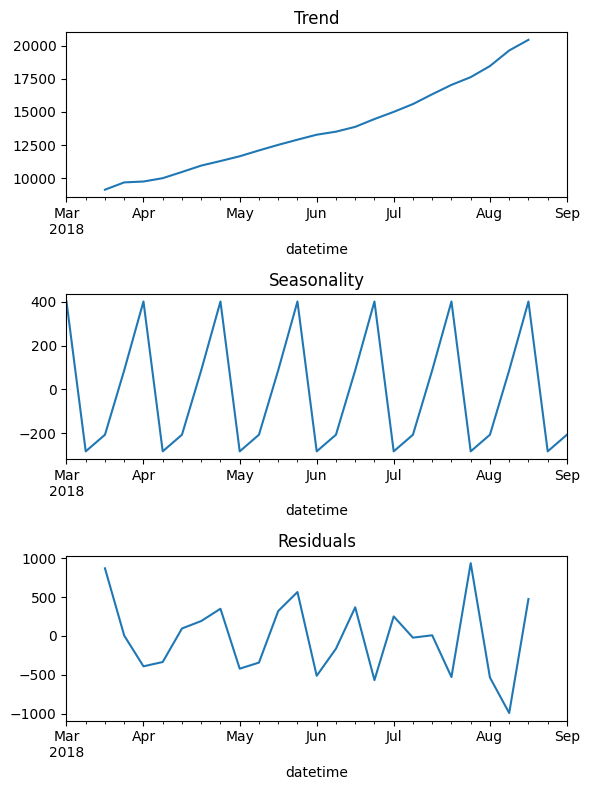

In [10]:
data = df.copy() #copia para mantener el df original
data = data.resample('1W').sum() #datos semanales para el análisis
decomposed = seasonal_decompose(data, period=4)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

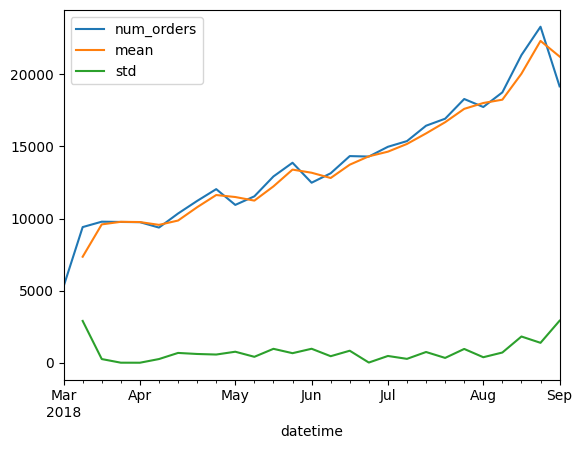

In [12]:
data['mean'] = data['num_orders'].rolling(2).mean() 
data['std'] = data['num_orders'].rolling(2).std()
data.plot()

Los datos tienen tendencia positiva, con un aumento en agosto, probablemente debido a vacaciones.

## Formación

Ahora vamos a preparar los datos y hacer una regresión lineal para predecir los viajes. Se usará el 90% de los datos como entrenamiento. Para aumentar la exactitud del modelo, se usará el defasado de datos.

In [17]:
def linear_model(max_lag, rolling_mean_size, data = df):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop('num_orders', axis= 1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    
    model = LinearRegression()
    model.fit(features_train, target_train)

    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    
    print("RSME para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train)**.5)
    print("RSME para el conjunto de prueba:", mean_squared_error(target_test, pred_test)**.5)

## Prueba

Ahora que tenemos la función, sólo que hay que probar con diferentes valores de max_lag y rolling_mean_size hasta encontrar los valores que nos den un RSME menor a 48

In [38]:
test_1 = linear_model(1, 5)

RSME para el conjunto de entrenamiento: 20.369662911656437
RSME para el conjunto de prueba: 34.599299804920456
CPU times: user 58.6 ms, sys: 81.4 ms, total: 140 ms
Wall time: 49 ms


In [20]:
test_2 = linear_model(1, 10)

RSME para el conjunto de entrenamiento: 31.707975795931336
RSME para el conjunto de prueba: 54.75107634289171


In [21]:
test_3 = linear_model(1, 24)

RSME para el conjunto de entrenamiento: 30.962935791219053
RSME para el conjunto de prueba: 51.16593780947741


In [22]:
test_4 = linear_model(1, 48)

RSME para el conjunto de entrenamiento: 30.93021303846482
RSME para el conjunto de prueba: 50.91113164521805


In [24]:
test_5 = linear_model(1, 72)

RSME para el conjunto de entrenamiento: 30.850624179051582
RSME para el conjunto de prueba: 50.69901885730396


In [26]:
test_6 = linear_model(3, 72)

RSME para el conjunto de entrenamiento: 30.68355852763459
RSME para el conjunto de prueba: 49.97808620990357


In [28]:
test_7 = linear_model(10, 72)

RSME para el conjunto de entrenamiento: 30.250339172718853
RSME para el conjunto de prueba: 49.95045347483596


In [34]:
test_8 = linear_model(10, 168)

RSME para el conjunto de entrenamiento: 29.242421318644656
RSME para el conjunto de prueba: 48.19700677228458


In [35]:
test_9 = linear_model(100, 168)

RSME para el conjunto de entrenamiento: 22.131778723128928
RSME para el conjunto de prueba: 39.60137291994307


In [36]:
test_10 = linear_model(100, 5)

RSME para el conjunto de entrenamiento: 22.175861787032133
RSME para el conjunto de prueba: 39.79265431009943


In [39]:
test_11 = linear_model(168, 5)

RSME para el conjunto de entrenamiento: 20.369662911656437
RSME para el conjunto de prueba: 34.599299804920456
CPU times: user 80.9 ms, sys: 92.4 ms, total: 173 ms
Wall time: 102 ms


In [42]:
test_12 = linear_model(500, 5)

RSME para el conjunto de entrenamiento: 19.882586745424945
RSME para el conjunto de prueba: 40.78720291435912


In [47]:
test_13 = linear_model(168, 100)

RSME para el conjunto de entrenamiento: 17.59309671600762
RSME para el conjunto de prueba: 37.47700166189451


Ya logramos el objetivo de obtener un RMSE menor a 48 en el conjunto de prueba jugando con los valores, y vemos que si se usa un valor demasiado alto para max_lag, pierde calidad el modelo. Vamos a quedarnos con el modelo de regresión lineal que utiliza shift 168 veces y usa una rolling mean de 5.

<div class="alert alert-block alert-success">

<b>Comentario del revisor</b> <a class="tocSkip"></a>

<b>Éxito</b> - Excelente implementación de análisis exploratorio y modelado predictivo. Has seguido un enfoque estructurado que demuestra una comprensión clara de los componentes clave de una serie temporal.

**Análisis Exploratorio:**

- El uso de `seasonal_decompose` con remuestreo semanal te permitió descomponer correctamente la serie en tendencia, estacionalidad y residuales. Esta es una herramienta poderosa para entender patrones subyacentes, y está muy bien aplicada aquí.
- La identificación de un aumento en agosto sugiere una buena interpretación del contexto estacional. Una posible mejora sería cuantificar esa estacionalidad o comparar con otros meses.
- También implementaste una visualización de la media móvil y desviación estándar, lo cual proporciona una perspectiva clara de la estabilidad o volatilidad en la demanda. Esto es muy valioso para anticipar la variabilidad del modelo.

**Modelado Predictivo:**

- La función `linear_model()` está bien diseñada y te permite experimentar con múltiples combinaciones de lags y medias móviles. Es positivo que mantengas los datos originales intactos y trabajes sobre una copia.
- Dividiste los datos de forma cronológica, lo cual es una práctica esencial para series temporales y evita fugas de datos (`shuffle=False`).
- La prueba sistemática de distintos hiperparámetros muestra un enfoque iterativo muy profesional. Evaluar el impacto de `max_lag` y `rolling_mean_size` ayuda a entender mejor la sensibilidad del modelo.
- Lograste cumplir con la métrica objetivo (RMSE < 48) y además sacaste una conclusión clara sobre el punto óptimo del modelo.

**Recomendaciones menores para fortalecer esta sección aún más:**

- Podrías visualizar las predicciones vs los valores reales del conjunto de prueba para reforzar la evaluación cualitativa del modelo.
- Sería útil encapsular los mejores parámetros encontrados (por ejemplo, `max_lag = 168`, `rolling_mean = 5`) en un comentario explícito o etiqueta, como parte del pipeline final.


</div>


# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48